# Imports
Importing tensorflow, time, numpy scipy and the bible.

In [ ]:
import tensorflow as tf
import time
import tensorflow
import tqdm.notebook as note
import numpy as np
import scipy
from google.colab import drive
drive.mount('/content/drive')
start = time.time()

Mounted at /content/drive


# Preprocessing
In this segment we convert them to lowercase, remove newlines and specialcharacters and split the text into word tokens.

In [ ]:
# opening the bible
with open("drive/MyDrive/Tensorflow/Week10/bible.txt",'r') as f:
  text = f.read()

# we replace all \n and convert to lower case
text = text.replace("\n"," ").lower() 

# We create a set of all characters which are not letters, so numbers and special characters
special_caracters = {i for i in text if not(i.isalpha())}
print(f"We remove {sorted(special_caracters)}")

# then for every special character, we replace it with blanks. We do this instead of simply removing them, so we don't create new words for example like here:
# ate. I like -> ateI like 


for c in  special_caracters:
  text = text.replace(c," ")

# because we could have a lot of spaces in a row, we make sure to trim them down, so that there is only between words
while text.find("  ")>-1:
  text = text.replace("  "," ")

# because we know only singlular spaces seperate the words, we can simply split by them. (the str.split() standard python function does this for us)
text = text.split()



No we want to only use the 10000 most commen words in our text.
Hence we need the set of all words used, there counts and the knowledge which word in our text corresponds to which words in our set of all words.

Convenietly tf.unique_with_counts, does that all for us.
Have a look at the documentation here: https://www.tensorflow.org/api_docs/python/tf/unique_with_counts

Because we noticed that indexing over tf.tensors is strangely slow, we will convert all the return values of tf.unique_with_counts to numpy arrays via the map function 

In [ ]:
token_set, indices, counts = map(lambda x:x.numpy(), tf.unique_with_counts(text))

# so we have now the counts of every word in our token_set in counts. If we sort so the values are decreasing and we take the 10000 element
# we know the value at which we have to cut off  
cut_off_val = sorted(counts,reverse=True)[10000]

# Here we create a dictionary that maps all the words we want to keep (hence to boolean matrix) to a singular id_number
vocab = {t.decode():i for i,t in enumerate(token_set[counts > cut_off_val])}
# and then we need a reverse dictionary to get the corresponding words back, for when we later want to have a look at the results
inverse_vocab = {vocab[a]:a for a in vocab}

# No it's time to remove all the words from our text, are not frequent enough
# We do this by a boolean mask
# for every word 'indices' hold the info to which position the word has in our token_set and counts
mask = np.array([counts[indices[i]] > cut_off_val for i in range(len(text))])

# Then we just apply our boolean mask here
text = np.array(text)[mask]


No that we have only the 10000 most common words, it's time for subsampling

In [ ]:
# We take the constant given in the homework
SUB_SAMPLING_CONSTANT=0.001

# Then because he have removed some words from our text our counts have to updated
_, new_indices, new_counts = map(lambda x:x.numpy(), tf.unique_with_counts(text))

# normalize counts to get frequencies
new_counts = new_counts.astype(float)/len(text) 

# Here we create a array which holds the frequncy for every word in the text
frequencies= np.array([new_counts[new_indices[i]] for i in range(len(text))])

# then we calculate the sub sampling probabilities by the formula specified in the homework (1+sqrt(freq/sub_sampling_constant)) * (sub_sampling_constant/freq)
sub_sampling_probs = np.array([(1 + np.sqrt(frequencies[i]/SUB_SAMPLING_CONSTANT))  * (SUB_SAMPLING_CONSTANT/frequencies[i]) for i in range(len(text)) ])

# and now we use np.random.random() to sample from a uniform distribution from 0 to 1 to create a booleab mask of the values we want to keep
# if our subsample is smaller then out sub_sampling probability we keep the word
sub_sampling_mask = np.array([np.random.random() <   sub_sampling_probs[i] for i in range(len(text))])

# then we just apply the boolean mask
text = text[sub_sampling_mask]

Now we have to calculate some values for later, when we do our negative sampling

In [ ]:
# A tf.int64 tensor of all the tate to be sampled
complete_data_to_be_sampled = tf.cast(tf.reshape(tf.convert_to_tensor(list(vocab.values())),[1,-1]),tf.int64)

# the word frequencies again after subsampling
_, new_indices, new_counts = map(lambda x:x.numpy(), tf.unique_with_counts(text))
new_counts = new_counts.astype(float)/len(text)  

Now all that's left is to convert our words to their respective columns and build the training dataset according to our context window

In [ ]:
# convert words to their ids
text = np.vectorize(lambda x: vocab[x])(text)

# Specify our context window size
CONTEXT_WINDOW_SIZE = 4


data = [] # aggregator for our data

for i in range(0,len(text)): #we go over all words

  for d in range(-CONTEXT_WINDOW_SIZE//2,CONTEXT_WINDOW_SIZE//2+1): # then over all words in the context window
    # add up both indices to get our position
    z = i+d

    if z>0 and z!=i  and z<len(text)-1: # if our position is valid (in the array range and not the word itself)
      data.append((text[i],text[z])) # append our data, the input on the left, the target on the right

BATCH_SIZE = 128 # specify our batch_size, 128 worked well for us

# Convert the data to a array  and ut some  last values of, so we can batch the data nicely
data = np.array(data)[:(len(data)//(BATCH_SIZE))*BATCH_SIZE]

# because we created an array, the inputs correspond to the first column and their respective targets to the second column

data =tf.data.Dataset.from_tensor_slices((data[:,0],data[:,1])) # create our data_set with inputs and targets
# print ds size
print(len(data))

# apply shuffling and batching
data = data.shuffle(1000).batch(BATCH_SIZE)

# Then this is VERY IMPORTANT
data = data.map(lambda a,b: (a,tf.reshape(b,(-1,1)))) # the labels must have shape (batchsize,1) or the nce won't work later

# Then let's do prefethinf and caching for performance
data = data.prefetch(20).cache()

2100608


# SkipGram Model

In [ ]:
class SkipGram(tf.keras.layers.Layer):
    """SkipGram Model to create word embeddings."""

    def __init__(self,embedding_size,vocabulary_size):
        """
        Construktor, calls super constructor and sets embedding and vocab size.
        ##Params
            - int embedding_size: embedding size
            - int vocabulary_size: vocabulary size
        """
        super(SkipGram,self).__init__()
        self.embedding_size= embedding_size
        self.vocabulary_size = vocabulary_size
        self.build("This value is not important, the build function just needs an argument") # call the build function

    def build(self,input_shape):
        """
        Initializing the embedding and score matrices
        ##Params
            - int input_shape = Useless filler argument
        """
        self.nce_weights = tf.Variable(tf.random.normal([self.vocabulary_size, self.embedding_size])) # we wnat the nce_weights to be randomly distributed at the start
        self.nce_biases = tf.Variable(tf.zeros([self.vocabulary_size])) # and the biases to be 0

        self.embedding = tf.Variable(tf.random.uniform([self.vocabulary_size, self.embedding_size])) # we choose a uniform random variable for the embedding matrix
  
    def call(self,words, labels):
      """ Getting embeddings using embedding_lookup and directly calculating and returning loss.
      ##Params
          - labels = labels
      """
      global new_counts # word frequencies for negative sampling
      global complete_data_to_be_sampled # all the data we can sample from

      number_of_negative_samples = 64 # we chose 64 negative sampled words

      # getting the embeddings
      words_embedded = tf.nn.embedding_lookup(self.embedding, words)

      # getting the sampled values for the negative sampling according to the word frequencies
      sampled_values=tf.random.fixed_unigram_candidate_sampler(complete_data_to_be_sampled,self.vocabulary_size,number_of_negative_samples,False,range_max=self.vocabulary_size,unigrams=new_counts)
      
      # calculate the loss, we give our sampled values to our nce_loss_function
      loss = tf.nn.nce_loss(weights=self.nce_weights,biases=self.nce_biases, labels=labels,  inputs=words_embedded,  num_sampled=number_of_negative_samples, num_classes=self.vocabulary_size,sampled_values=sampled_values)

      # the mean is taken over all the batches
      return tf.reduce_mean(loss)
     



# Print closest word function
Prints out closest word in specified model. 

In [ ]:
def print_closest_word(Model,words_of_interest):
    """
    Prints what specified model characterised as closest words to list of
    given words.
    ##Params 
        - tf.keras.layers.Layer Model = specified tensorflow model
        - stringlist words_of_interest = words we want to know similarity of
    """
    # convert our embedding matrix to a numpy array, so we can quickly do some operations
    ar = Model.embedding.numpy()
    # for all words of interest
    for word in words_of_interest:

        i = vocab[word] # get the id of the word

        # get the index of the closest word via np.argmin (returns the index of the minimal value) and the scipy.spatial.distance.cosine function, which calculate the spatial cosine distance for us
        # if we have the same word, we want the distance to be infitive

        closest = np.argmin([scipy.spatial.distance.cosine(ar[i],ar[q]) if q!=i else np.inf for q in range(len(ar)) ])

        # then print the word again, via the use of our inverse vocab
        print(f"Closest to {word} is {inverse_vocab[closest]}")

# Running our Code

In [ ]:
tf.keras.backend.clear_session()

# interesting words
words_of_interesting = ["holy", "father", "wine", "poison", "love", "strong", "day"]

# define hyperparams
learning_rate = tf.constant(0.001, dtype=tf.float64) # A smaller learning rate prooved to be more useful

num_epochs = 10
hidden_size = 64

VOCAB_SIZE = len(vocab)
Model = SkipGram(hidden_size,VOCAB_SIZE)

optimizer = tf.optimizers.Adam(learning_rate)    

train_losses = np.empty(0)


start_time = time.time()

# training of our model for num_epochs
for epoch in range(num_epochs):
    print(f'Epoch {str(epoch)}')

    epoch_loss_agg = np.empty(0)

    # Loop over all our training data with nice progress bar
    for input, target in note.tqdm(data,position=0,leave=True):
      
      with tf.GradientTape() as tape:
        loss = Model(input,target) # get the loss
      # Apply the gradients as always 
      gradients = tape.gradient(loss, Model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, Model.trainable_variables))
      epoch_loss_agg = np.append(epoch_loss_agg, loss)
                   
    train_losses = np.append(train_losses, tf.reduce_mean(epoch_loss_agg))            
                   
    used_time = np.round(time.time()-start_time)
    print(f"Finished epoch {epoch+1}, it took {used_time //60} minutes, {used_time%60} seconds")
    print(train_losses[-1])
    # after an epoch print all the closest words
    print_closest_word(Model,words_of_interesting)
    start_time = time.time()

Epoch 0


  0%|          | 0/16411 [00:00<?, ?it/s]

Finished epoch 1, it took 11.0 minutes, 22.0 seconds
528.7479624500382
Closest to holy is pasture
Closest to father is once
Closest to wine is belly
Closest to poison is threw
Closest to love is cow
Closest to strong is debtors
Closest to day is special
Epoch 1


  0%|          | 0/16411 [00:00<?, ?it/s]

Finished epoch 2, it took 11.0 minutes, 22.0 seconds
335.42551985990485
Closest to holy is pasture
Closest to father is thy
Closest to wine is unlawful
Closest to poison is ambassador
Closest to love is knife
Closest to strong is wanting
Closest to day is rod
Epoch 2


  0%|          | 0/16411 [00:00<?, ?it/s]

Finished epoch 3, it took 10.0 minutes, 55.0 seconds
289.81710915568107
Closest to holy is strengthening
Closest to father is hath
Closest to wine is unlawful
Closest to poison is ambassador
Closest to love is less
Closest to strong is goads
Closest to day is him
Epoch 3


  0%|          | 0/16411 [00:00<?, ?it/s]

Finished epoch 4, it took 11.0 minutes, 22.0 seconds
257.52780181213456
Closest to holy is full
Closest to father is hath
Closest to wine is unlawful
Closest to poison is tahath
Closest to love is less
Closest to strong is goads
Closest to day is when
Epoch 4


  0%|          | 0/16411 [00:00<?, ?it/s]

Finished epoch 5, it took 10.0 minutes, 42.0 seconds
232.85427208102516
Closest to holy is god
Closest to father is hath
Closest to wine is unlawful
Closest to poison is tahath
Closest to love is chenaniah
Closest to strong is quiet
Closest to day is time
Epoch 5


  0%|          | 0/16411 [00:00<?, ?it/s]

Finished epoch 6, it took 11.0 minutes, 22.0 seconds
213.57752926520635
Closest to holy is god
Closest to father is hath
Closest to wine is unlawful
Closest to poison is tahath
Closest to love is proud
Closest to strong is quiet
Closest to day is time
Epoch 6


  0%|          | 0/16411 [00:00<?, ?it/s]

Finished epoch 7, it took 11.0 minutes, 22.0 seconds
200.5576140634045
Closest to holy is for
Closest to father is hath
Closest to wine is white
Closest to poison is tahath
Closest to love is proud
Closest to strong is quiet
Closest to day is time
Epoch 7


  0%|          | 0/16411 [00:00<?, ?it/s]

Finished epoch 8, it took 11.0 minutes, 22.0 seconds
191.5724905105971
Closest to holy is full
Closest to father is hath
Closest to wine is white
Closest to poison is hoary
Closest to love is evil
Closest to strong is quiet
Closest to day is now
Epoch 8


  0%|          | 0/16411 [00:00<?, ?it/s]

Finished epoch 9, it took 10.0 minutes, 50.0 seconds
186.0451489344469
Closest to holy is full
Closest to father is hath
Closest to wine is white
Closest to poison is hoary
Closest to love is works
Closest to strong is quiet
Closest to day is when
Epoch 9


  0%|          | 0/16411 [00:00<?, ?it/s]

Finished epoch 10, it took 10.0 minutes, 37.0 seconds
182.14979519750204
Closest to holy is full
Closest to father is hath
Closest to wine is white
Closest to poison is companion
Closest to love is works
Closest to strong is wine
Closest to day is when


##Analysis of our model


We can see that at first, as one would expect, the closest words are quite random, like "Closest to love is cow".

<br /> 
Then at around epoch 6 we can already se some relationships, which make sence. Like:
<br /> 


*   "Closest to holy is god" - probalby most christians would agree to this
*   "Closest to day is time" - makes perfect sence
<br /> 

But then as we keep training and loss is going down, our results seem to become a bid strange again. This are the result for the last epoch:

<br /> 


*   "Closest to holy is full"
*   "Closest to father is hath"
*   "Closest to wine is white"
*   "Closest to poison is companion"
*   "Closest to love is works"
*   "Closest to strong is wine"
*   "Closest to day is at"
<br /> 

While strong white wine is a lovely companion that works almost always, we are still a bit suprised by the sudden shift away from what makes sence to us.

Our suspission, is that the negative sampling is overweighing the positive samples.

<br /> 


Because this would not be a proper vord2vec implementation, if we did not test this, we ofcourse have to make the $king-man+woman \:?= queen$ test:

In [ ]:
ar = Model.embedding.numpy()
hopefully_queen = ar[vocab["king"]]-ar[vocab["man"]]+ar[vocab["woman"]]
closest = np.argmin([scipy.spatial.distance.cosine(hopefully_queen,ar[q])  for q in range(len(ar)) ])
print(f"Closest to king-man+woman is {inverse_vocab[closest]}")

Closest to king-man+woman is king


Well that is a bit disappointing

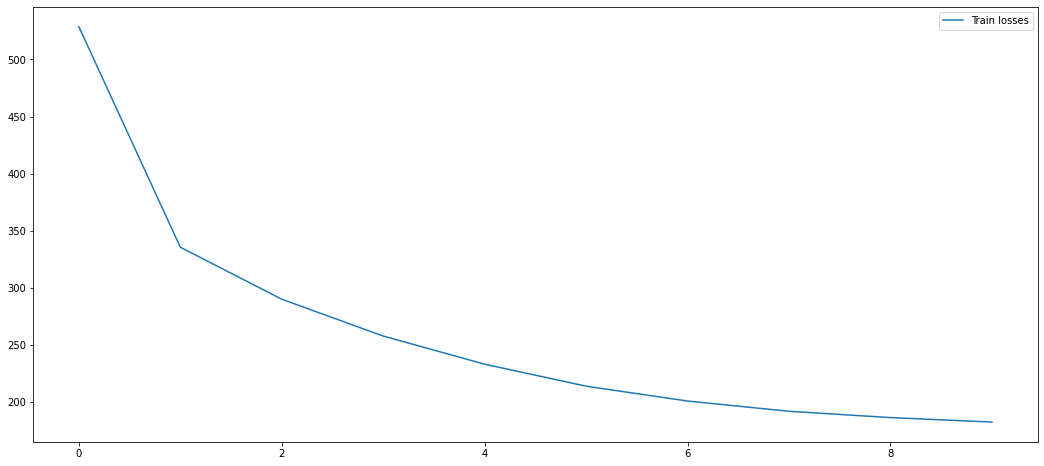

In [ ]:
import matplotlib.pyplot as plt # plot the values nicely
plt.figure(figsize=(18,8))
plt.plot(range(num_epochs),train_losses, label="Train losses")
plt.legend()
plt.show()